In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas scikit-learn matplotlib numpy graphviz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Predicting baseball games

In [3]:
df = pd.read_csv('../data/baseball/training/game_data_v6.csv')

In [4]:
def create_data(drop_cols=['away_score', 'home_score', 'away_team', 'home_team'], y_col='away_score', split_by='random'):
    y = df[y_col]
    x = df.drop(drop_cols, axis=1)

    if split_by == 'season':
        x_train, x_test = x.iloc[0:13047], x.iloc[13047:]
        y_train, y_test = y.iloc[0:13047], y.iloc[13047:]
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
    
    return x_train, x_test, y_train, y_test

### Splitting the data

Split the game data for training and testing, either by seasons (2017-22 for training, 2023 for testing) or randomly.

In [107]:
# add output columns (scores) to separate dataset
y = df['away_score']
# y = pd.DataFrame({'away_score': df['away_score'], 'home_score': df['home_score']})
# y = pd.DataFrame({'home_win': df['home_score'] > df['away_score']})['home_win']

# remove output columns and team names from input dataset
x = df.drop(['away_score', 'home_score', 'away_team', 'home_team', 'away_team_xfip', 'away_starter_xfip', 'home_team_xwoba_diff', 'home_lineup_xwoba'], axis=1)
# x = df.drop(['away_score', 'home_score', 'away_team', 'home_team'], axis=1)

In [32]:
# split by seasons (train=2017-2022, test=2023)
x_train, x_test = x.iloc[0:13047], x.iloc[13047:]
y_train, y_test = y.iloc[0:13047], y.iloc[13047:]

In [108]:
# split randomly
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)

### Models

* Random forest regressor
* Random forest classifier
* Decision tree regressor
* Linear regression
* Logistic regression

In [20]:
# model = MultiOutputRegressor(RandomForestRegressor(n_estimators=500, max_depth=7, max_features='sqrt', random_state=100))
model_away = RandomForestRegressor(n_estimators=5, max_features='sqrt', min_samples_leaf=2)
model_home = RandomForestRegressor(n_estimators=5, max_features='sqrt', min_samples_leaf=2)

In [300]:
model_away = DecisionTreeRegressor(max_depth=50, min_samples_leaf=10)
model_home = DecisionTreeRegressor(max_depth=50, min_samples_leaf=10)

In [184]:
model = RandomForestClassifier(n_estimators=500, max_depth=7, max_features='sqrt', random_state=100)

In [237]:
# model = MultiOutputRegressor(LinearRegression())
model_away = LinearRegression()
model_home = LinearRegression()

In [143]:
model = LogisticRegression()

In [24]:
model_cv = GridSearchCV(estimator=MultiOutputRegressor(RandomForestRegressor()),
                        param_grid={
                            'estimator__n_estimators': [],
                            'estimator__max_depth': [2, 4, 6, 8, 10],
                        },
                        # scoring={
                        #     'accuracy': make_scorer(wl_accuracy),
                        # },
                        # refit='accuracy',
                        cv=5)

### Training

In [14]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team'],
                                                                              # 'away_team_xfip', 'away_starter_xfip',
                                                                              # 'home_team_xwoba_diff', 'home_lineup_xwoba'],
                                                                   y_col='away_score',
                                                                   split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team'],
                                                                              # 'home_team_xfip', 'home_starter_xfip',
                                                                              # 'away_team_xwoba_diff', 'away_lineup_xwoba'],
                                                                   y_col='home_score',
                                                                   split_by='season')

In [21]:
# model_cv.fit(x, y)
# pd.DataFrame(model_cv.cv_results_)
model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=5)

In [41]:
feature_importances = {
    'feature': [],
    'weight': []
}

cols = x_train_home.columns

for i in range(len(cols)):
    feature_importances['feature'].append(cols[i])
    feature_importances['weight'].append(f'{round(model_home.feature_importances_[i] * 100, 2)}%')

print('Feature importances for predicting home team score:')
pd.DataFrame(feature_importances)

Feature importances for predicting home team score:


,feature,weight
0,away_team_xwoba_diff,5.92%
1,away_lineup_xwoba,11.91%
2,away_team_xfip,6.53%
3,away_starter_xfip,12.17%
4,away_close_win_pct,5.74%
5,away_run_diff,6.73%
6,home_team_xwoba_diff,6.71%
7,home_lineup_xwoba,13.2%
8,home_team_xfip,6.43%
9,home_starter_xfip,11.35%


In [22]:
pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

,away_pred,home_pred,away_true,home_true
count,2430.000000,2430.000000,2430.000000,2430.000000
mean,4.548745,4.760562,4.634979,4.596296
std,1.461734,1.438196,3.285711,3.150994
min,0.511905,1.246667,0.000000,0.000000
25%,3.495595,3.695000,2.000000,2.000000
50%,4.411667,4.635000,4.000000,4.000000
75%,5.483333,5.657639,6.000000,6.000000
max,10.206667,10.344444,25.000000,20.000000


In [23]:
print(f'W/L accuracy: {wl_accuracy(results)}%')

W/L accuracy: 54.73251028806584%


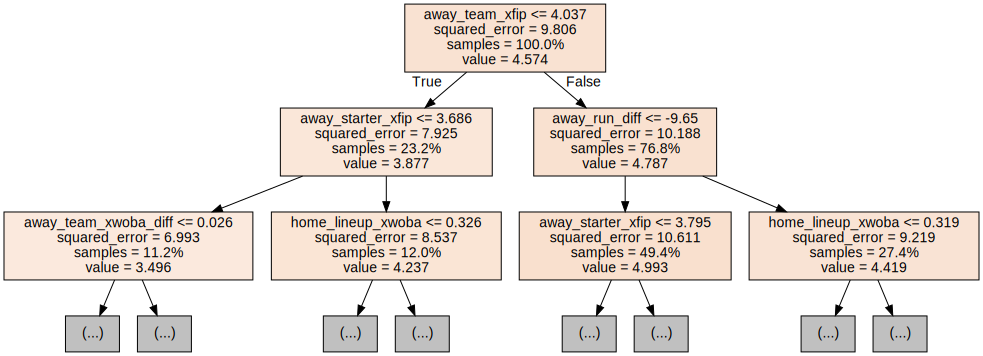

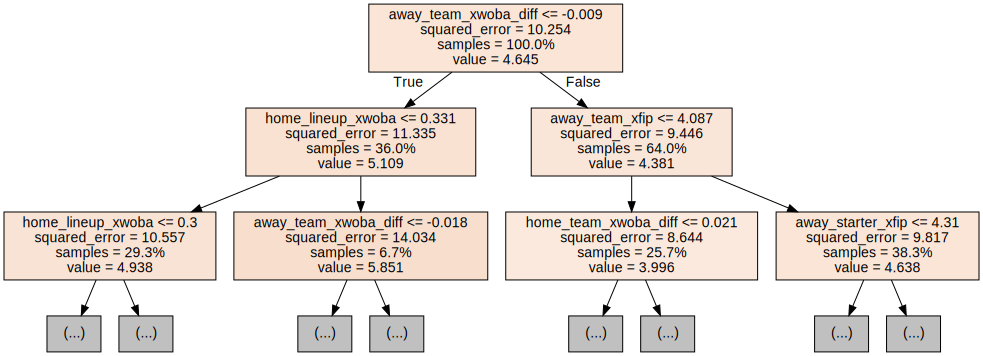

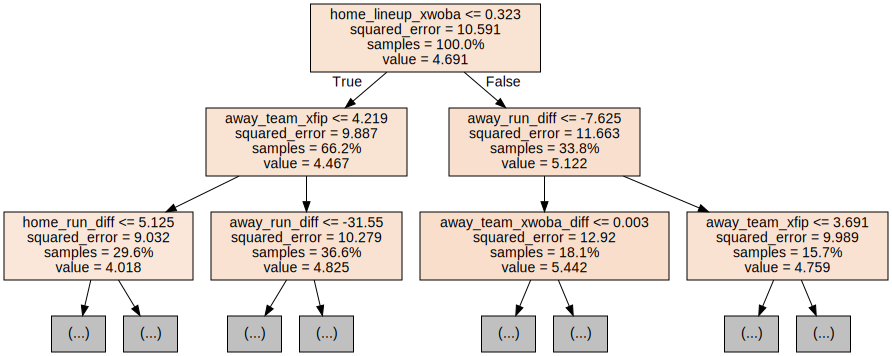

In [26]:
# visualizing decision trees
# https://www.datacamp.com/tutorial/random-forests-classifier-python

for i in range(3):
    tree = model_home.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train_home.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=True, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### Metrics

* W/L accuracy

In [10]:
def wl_accuracy(results):
    num_correct = 0
    num_incorrect = 0
    
    for i in range(len(results)):
        away_score_pred = results['away_pred'].iloc[i]
        home_score_pred = results['home_pred'].iloc[i]
        away_score_actual = results['away_true'].iloc[i]
        home_score_actual = results['home_true'].iloc[i]
    
        pred_result = 1 if home_score_pred > away_score_pred else 0 # where 1 = home team wins
        actual_result = 1 if home_score_actual > away_score_actual else 0
    
        # pred_result = pred[i]
        # actual_result = y_test.iloc[i]
        
        if pred_result == actual_result:
            num_correct += 1
        else:
            num_incorrect += 1

    return (num_correct / (num_correct + num_incorrect)) * 100

### Misc

In [8]:
test_df = pd.read_csv('../data/game_data_test.csv')
test_df_y = pd.DataFrame({'away_score': test_df['away_score'], 'home_score': test_df['home_score']})
test_df_x = test_df.drop(['away_score', 'home_score', 'away_team', 'home_team'], axis=1)

In [78]:
mean_squared_error(y_test, pred)

np.float64(9.832976724680288)

In [148]:
model.score(x_test, y_test)

0.5930041152263374

In [24]:
# calculate season records based on predictions

team_records = {
    'HOU': 0,
    'TEX': 0,
    'LAA': 0,
    'OAK': 0,
    'SEA': 0,

    'KC': 0,
    'DET': 0,
    'CLE': 0,
    'MIN': 0,
    'CWS': 0,

    'NYY': 0,
    'BOS': 0,
    'TB': 0,
    'TOR': 0,
    'BAL': 0,
    
    'LAD': 0,
    'SD': 0,
    'COL': 0,
    'AZ': 0,
    'SF': 0,
    
    'MIL': 0,
    'PIT': 0,
    'STL': 0,
    'CIN': 0,
    'CHC': 0,

    'NYM': 0,
    'ATL': 0,
    'PHI': 0,
    'WSH': 0,
    'MIA': 0,
}

for i in range(len(results)):
    away_team = df['away_team'].iloc[13047 + i]
    home_team = df['home_team'].iloc[13047 + i]
    home_team_won = results['away_pred'].iloc[i] < results['home_pred'].iloc[i]

    if away_team not in team_records:
        team_records[away_team] = 0

    if home_team not in team_records:
        team_records[home_team] = 0

    team_records[away_team] += 1 if not home_team_won else 0
    team_records[home_team] += 1 if home_team_won else 0

counter = 0
for team in team_records:
    counter += 1
    print(f'{team}: {team_records[team]}-{162-team_records[team]}')
    if counter % 5 == 0:
        print()

HOU: 89-73
TEX: 94-68
LAA: 78-84
OAK: 40-122
SEA: 109-53

KC: 61-101
DET: 69-93
CLE: 75-87
MIN: 95-67
CWS: 39-123

NYY: 91-71
BOS: 76-86
TB: 90-72
TOR: 96-66
BAL: 73-89

LAD: 114-48
SD: 77-85
COL: 48-114
AZ: 82-80
SF: 112-50

MIL: 117-45
PIT: 32-130
STL: 72-90
CIN: 59-103
CHC: 84-78

NYM: 88-74
ATL: 134-28
PHI: 107-55
WSH: 52-110
MIA: 77-85



In [13]:
y_test.describe()

,away_score,home_score
count,3870.000000,3870.000000
mean,4.500000,4.618346
std,3.278709,3.171390
min,0.000000,0.000000
25%,2.000000,2.000000
50%,4.000000,4.000000
75%,6.000000,6.000000
max,23.000000,29.000000


In [14]:
pred_df = pd.DataFrame(pred)
pred_df.describe()

,0,1
count,3870.000000,3870.000000
mean,4.537641,4.615074
std,0.717161,0.574472
min,2.698911,3.096834
25%,4.013560,4.178820
50%,4.477279,4.570011
75%,4.990540,5.061605
max,12.015393,6.738227


Correlation coefficient (away team): r=0.21497074779894154
Correlation coefficient (home team): r=0.20828820312352855


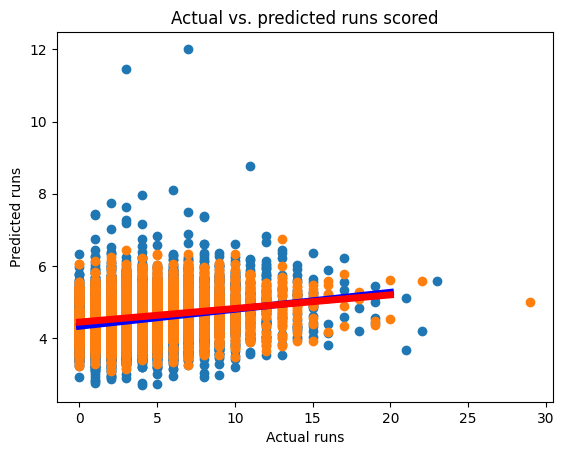

In [15]:
# drawing a scatterplot with regression line
# https://python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib/

plt.scatter(y_test['away_score'], pred_df[0])
plt.scatter(y_test['home_score'], pred_df[1])


m_away, b_away = np.polyfit(y_test['away_score'], pred_df[0], deg=1)
x_away = np.linspace(0, 20, num=1000)

plt.plot(x_away, m_away * x_away + b_away, color='b', lw=5)

r_away = np.corrcoef(y_test['away_score'], pred_df[0])
print(f'Correlation coefficient (away team): r={r_away[0][1]}')


m_home, b_home = np.polyfit(y_test['home_score'], pred_df[1], deg=1)
x_home = np.linspace(0, 20, num=1000)

plt.plot(x_home, m_home * x_home + b_home, color='r', lw=5)

r_home = np.corrcoef(y_test['home_score'], pred_df[1])
print(f'Correlation coefficient (home team): r={r_home[0][1]}')


plt.xlabel('Actual runs')
plt.ylabel('Predicted runs')
plt.title('Actual vs. predicted runs scored')

plt.show()

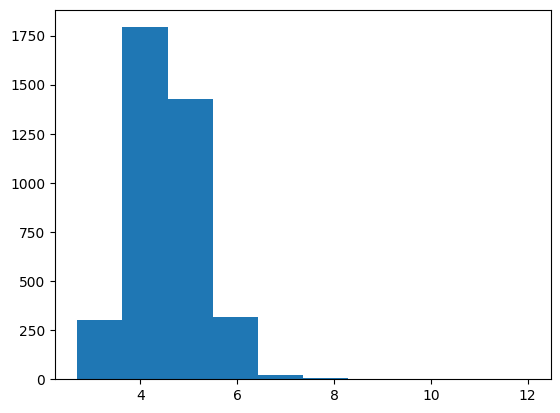

In [16]:
plt.hist(pred_df[0])
plt.show()

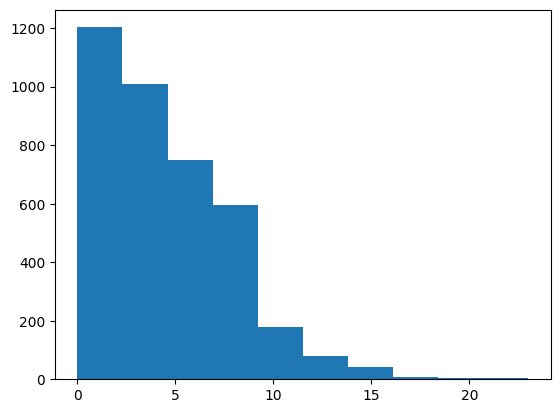

In [17]:
plt.hist(y_test['away_score'])
plt.show()

In [64]:
0.19371346717243468 ** 2

0.03752490736396593

In [78]:
# why is standard deviation so low? -> should it be that way?
# try a logistic regression for comparison

# experiment with monthly stats
# grid search cv


# experiment with past 2 season data - pretty much the same
# build a histogram of runs predicted
# figure out rookie average stats